# HW5 
Your goal is to add the following three things to your implementation of the REINFORCE algorithm and to quantify the impact of these things when training an agent for the grid_world environment:

    Importance sampling. REINFORCE is an on-policy algorithm. Importance sampling can be used to produce an off-policy variant of this algorithm. The benefits of using off-policy learning in policy gradient methods are similar to those you discovered in the context of value function methods with "experience replay." Keep a history of trajectories (with log-probabilities and rewards) and choose a subset of them for mini-batch training at each step of REINFORCE.

    Causality. REINFORCE depends on having a good estimate of the policy gradient. This estimate is obtained by computing a sample mean - the average gradient over some number of sampled trajectories. If the variance of the gradient is high, then many samples are required to obtain a good estimate of the mean. One way to reduce the variance is to eliminate any term in the gradient whose mean is known to be identically zero. (If you know a quantity is zero in expectation, why estimate it?) The idea of "causality" is that the reward at a given time should not - in expectation - depend on actions taken at any later time. Modify your computation of the gradient to eliminate terms that are zero due to "causality."

    Baseline shift. It is possible to show that the gradient of J(theta) and the gradient of J(theta) - b have the same mean for any b but can have different variance. "Baseline shift" means choosing b to minimize the variance. Modify your computation of the gradient to incorporate baseline shift. Remember that b is chosen element-wise - a different value of b is best for each component of theta.


## Memory and Post processing Modules

In [8]:
import numpy as np 
import matplotlib.pyplot as plt
from GridWorld import GridWorld

# Saving an episode
class Memory(object):
    def __init__(self):
        self.state= [[[] for j in range(batch_num)] for i in range(episode_num)]
        self.action= [[[] for j in range(batch_num)] for i in range(episode_num)]
        self.reward= [[[] for j in range(batch_num)] for i in range(episode_num)]
        self.logp= [[[] for j in range(batch_num)] for i in range(episode_num)]
        self.episode_lim = 0

    def store_transition(self, episode, batch, state, action, logp, reward):
        self.state[episode][batch].append(state)
        self.action[episode][batch].append(action)
        self.reward[episode][batch].append(reward)
        self.logp[episode][batch].append(logp)

        self.episode_lim = np.maximum(self.episode_lim, episode)

    def convert_to_array(self, episode, batch):
        array_state = np.array(self.state[episode][batch])
        array_action = np.array(self.action[episode][batch])
        array_reward = np.array(self.reward[episode][batch])
        return array_state, array_action, array_reward

    def get_rand_policy(self, episode, batch):

        return np.exp(self.logp[episode][np.maximum(batch, 0)][0]), np.exp(self.logp[episode][batch][0])

    def reset(self):
        self.state= [[[] for j in range(batch_num)] for i in range(episode_num)]
        self.action= [[[] for j in range(batch_num)] for i in range(episode_num)]
        self.reward= [[[] for j in range(batch_num)] for i in range(episode_num)]
        self.logp= [[[] for j in range(batch_num)] for i in range(episode_num)]
        self.episode_lim = 0

class PostProcess(object):
    def __init__(self):
        self.ep_reward = 0
        self.total_reward = []

    def rew_acu(self, reward):
        self.ep_reward = self.ep_reward + reward

    def push(self, episode):
        self.total_reward.append(self.ep_reward)
        #print('epoch',episode,' | reward', self.ep_reward)
        self.ep_reward = 0

    def graph(self):
        plt.plot(self.total_reward)
        plt.show()

    def get_reward(self):
        return self.total_reward

    def reset(self):
        self.ep_reward = 0
        self.total_reward = []

## Tabular policy and Agent Modules

In [9]:
class Table(object):
    def __init__(self, state_dim, act_dim, lr):
        self.q_table = np.random.uniform(low= 0.0001, high= 1, size= [act_dim, state_dim])
        self.lr = lr

    def policy_gen(self, state):
        y = self.q_table[:, state]
        policy_prob = np.divide(np.exp(y), np.sum(np.exp(y)))
        return policy_prob

    def gradeint_descent(self, state, action, g):
        x = np.zeros_like(self.q_table)
        y = np.zeros_like(self.q_table)

        x[action, state] = 1

        y[:, state] = np.exp(self.q_table[:, state])
        y = np.divide(y, np.sum(y))

        dJ = self.lr*g*(x - y)

        self.q_table = self.q_table + dJ

    def get_table(self):
        return self.q_table

    def reset(self):
        self.q_table = np.random.uniform(low= 0.0001, high= 1, size= [4, 25])





class Agent(object):
    def __init__(self, state_dim, act_dim, lr):
        self.table = Table(state_dim, act_dim, lr)
        self.v_weight = np.random.uniform(size= [25, 1])
        self.lr = lr
        self.memory = Memory()

    def get_action(self, state):
        policy = self.table.policy_gen(state)
        action = np.random.choice(range(4), p= policy.ravel())

        return self.table.get_table(), action

    def update_policy(self, episode, batch, causality, baseline, importance):
        im_n = 0
        im_d = 0
        state, action, reward = self.memory.convert_to_array(episode, batch)

        g = self.compute_g_value(reward)

        for t in range(batch_size):
            if baseline == 'on':
                v = self.compute_v_value(state[t])
            elif baseline == 'off':
                v = 0

            if causality == 'on':
                delta = g[0][t] - v
            elif causality == 'off':
                delta = np.sum(reward)/batch_size - v

            if importance == 'on':
                for i in range(len(reward)):
                    a, b = self.memory.get_rand_policy(episode, batch)
                    im_d += np.log(a[action[i]][state[i]]/np.sum(a[:, state[i]]))
                    im_n += np.log(b[action[i]][state[i]]/np.sum(b[:, state[i]]))

                delta = delta*np.exp(im_n- im_d)

            self.table.gradeint_descent(state[t], action[t], delta)
            self.update_v_weight(state[t], delta)


    def compute_g_value(self, reward):
        g_value = np.zeros_like(reward, dtype= np.float32)
        value = 0
        for t in reversed(range(0, len(reward))):
            value = value + reward[t]
            g_value[t] = value
        return [g_value[:, np.newaxis]]

    def compute_v_value(self, state):
        value= self.v_weight[state][0]
        return value
    
    def update_v_weight(self, state, delta):
        self.v_weight[state][0] += 0.01*delta
class Table(object):
    def __init__(self, state_dim, act_dim, lr):
        self.q_table = np.random.uniform(low= 0.0001, high= 1, size= [act_dim, state_dim])
        self.lr = lr

    def policy_gen(self, state):
        y = self.q_table[:, state]
        policy_prob = np.divide(np.exp(y), np.sum(np.exp(y)))
        return policy_prob

    def gradeint_descent(self, state, action, g):
        x = np.zeros_like(self.q_table)
        y = np.zeros_like(self.q_table)

        x[action, state] = 1

        y[:, state] = np.exp(self.q_table[:, state])
        y = np.divide(y, np.sum(y))

        dJ = self.lr*g*(x - y)

        self.q_table = self.q_table + dJ

    def get_table(self):
        return self.q_table

    def reset(self):
        self.q_table = np.random.uniform(low= 0.0001, high= 1, size= [4, 25])





class Agent(object):
    def __init__(self, state_dim, act_dim, lr):
        self.table = Table(state_dim, act_dim, lr)
        self.v_weight = np.random.uniform(size= [25, 1])
        self.lr = lr
        self.memory = Memory()

    def get_action(self, state):
        policy = self.table.policy_gen(state)
        action = np.random.choice(range(4), p= policy.ravel())

        return self.table.get_table(), action

    def update_policy(self, episode, batch, causality, baseline, importance):
        im_n = 0
        im_d = 0
        state, action, reward = self.memory.convert_to_array(episode, batch)

        g = self.compute_g_value(reward)

        for t in range(batch_size):
            if baseline == 'on':
                v = self.compute_v_value(state[t])
            elif baseline == 'off':
                v = 0

            if causality == 'on':
                delta = g[0][t] - v
            elif causality == 'off':
                delta = np.sum(reward)/batch_size - v

            if importance == 'on':
                for i in range(len(reward)):
                    a, b = self.memory.get_rand_policy(episode, batch)
                    im_d += np.log(a[action[i]][state[i]]/np.sum(a[:, state[i]]))
                    im_n += np.log(b[action[i]][state[i]]/np.sum(b[:, state[i]]))

                delta = delta*np.exp(im_n- im_d)

            self.table.gradeint_descent(state[t], action[t], delta)
            self.update_v_weight(state[t], delta)


    def compute_g_value(self, reward):
        g_value = np.zeros_like(reward, dtype= np.float32)
        value = 0
        for t in reversed(range(0, len(reward))):
            value = value + reward[t]
            g_value[t] = value
        return [g_value[:, np.newaxis]]

    def compute_v_value(self, state):
        value= self.v_weight[state][0]
        return value
    
    def update_v_weight(self, state, delta):
        self.v_weight[state][0] += 0.01*delta


## Initialize Easy Grid World Env

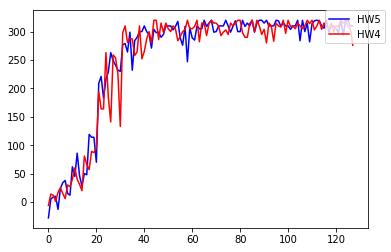

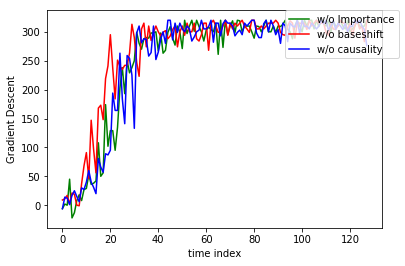

In [10]:
#initialize the environment
env = GridWorld()
#initialize learning module with number of states and action
state_dim = 25
action_dim = 4

#set number of episodes and time steps
episode_num = 128
batch_num = 8
batch_size = 16

# define exploring agent
worker = Agent(state_dim, action_dim, 0.01)

gprocess = PostProcess()
im_process = PostProcess()
base_process = PostProcess()
caus_process = PostProcess()

#testing gradient policy based learning
for i_episode in range(episode_num):

    #reinitialize environment for new episode
    observation_old = env.reset()

    for i_batch_num in range(batch_num):

        for i_batch_size in range(batch_size):

            #render the environment graphics
            #env.render()

            # Policy Gradient
            policy, action = worker.get_action(observation_old)

            #run environment 
            observation, reward = env.step(action, 0)

            worker.memory.store_transition(i_episode, i_batch_num, observation_old, action, policy, reward)

            observation_old = observation

            gprocess.rew_acu(reward)

        worker.update_policy(i_episode, i_batch_num, causality= 'on', baseline= 'on', importance= 'on')

    gprocess.push(i_episode)

worker.memory.reset()
worker.table.reset()

#testing gradient policy based learning
for i_episode in range(episode_num):

    #reinitialize environment for new episode
    observation_old = env.reset()

    for i_batch_num in range(batch_num):

        for i_batch_size in range(batch_size):

            #render the environment graphics
            #env.render()

            # Policy Gradient
            policy, action = worker.get_action(observation_old)

            #run environment 
            observation, reward = env.step(action, 0)

            worker.memory.store_transition(i_episode, i_batch_num, observation_old, action, policy, reward)

            observation_old = observation

            im_process.rew_acu(reward)

        worker.update_policy(i_episode, i_batch_num, causality= 'on', baseline= 'on', importance= 'off')

    im_process.push(i_episode)

worker.memory.reset()
worker.table.reset()
#testing gradient policy based learning
for i_episode in range(episode_num):

    #reinitialize environment for new episode
    observation_old = env.reset()

    for i_batch_num in range(batch_num):

        for i_batch_size in range(batch_size):

            #render the environment graphics
            #env.render()

            # Policy Gradient
            policy, action = worker.get_action(observation_old)

            #run environment 
            observation, reward = env.step(action, 0)

            worker.memory.store_transition(i_episode, i_batch_num, observation_old, action, policy, reward)

            observation_old = observation

            base_process.rew_acu(reward)

        worker.update_policy(i_episode, i_batch_num, causality= 'on', baseline= 'off', importance= 'on')

    base_process.push(i_episode)

worker.memory.reset()
worker.table.reset()
#testing gradient policy based learning
for i_episode in range(episode_num):

    #reinitialize environment for new episode
    observation_old = env.reset()

    for i_batch_num in range(batch_num):

        for i_batch_size in range(batch_size):

            #render the environment graphics
            #env.render()

            # Policy Gradient
            policy, action = worker.get_action(observation_old)

            #run environment 
            observation, reward = env.step(action, 0)

            worker.memory.store_transition(i_episode, i_batch_num, observation_old, action, policy, reward)

            observation_old = observation

            caus_process.rew_acu(reward)

        worker.update_policy(i_episode, i_batch_num, causality= 'on', baseline= 'off', importance= 'off')

    caus_process.push(i_episode)


plt.figure(0)
plt.plot(gprocess.get_reward(), 'b', label= 'HW5')
plt.plot(caus_process.get_reward(), 'r', label= 'HW4')
plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)

plt.figure(1)
plt.plot(im_process.get_reward(), 'g', label= 'w/o Importance')
plt.plot(base_process.get_reward(), 'r', label= 'w/o baseshift')
plt.plot(caus_process.get_reward(), 'b', label= 'w/o causality')
plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)

plt.ylabel('Gradient Descent')
plt.xlabel('time index')

plt.show()


## Hard Grid World

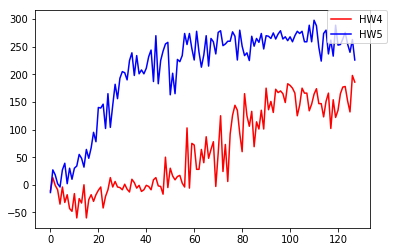

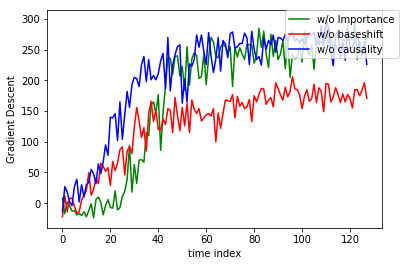

In [17]:
worker.memory.reset()
worker.table.reset()

gprocess.reset()
im_process.reset()
base_process.reset()
caus_process.reset()

#testing gradient policy based learning
for i_episode in range(episode_num):

    #reinitialize environment for new episode
    observation_old = env.reset()

    for i_batch_num in range(batch_num):

        for i_batch_size in range(batch_size):

            #render the environment graphics
            #env.render()

            # Policy Gradient
            policy, action = worker.get_action(observation_old)

            #run environment 
            observation, reward = env.step(action, 1)

            worker.memory.store_transition(i_episode, i_batch_num, observation_old, action, policy, reward)

            observation_old = observation

            gprocess.rew_acu(reward)

        worker.update_policy(i_episode, i_batch_num, causality= 'on', baseline= 'on', importance= 'on')

    gprocess.push(i_episode)

worker.memory.reset()
worker.table.reset()

#testing gradient policy based learning
for i_episode in range(episode_num):

    #reinitialize environment for new episode
    observation_old = env.reset()

    for i_batch_num in range(batch_num):

        for i_batch_size in range(batch_size):

            #render the environment graphics
            #env.render()

            # Policy Gradient
            policy, action = worker.get_action(observation_old)

            #run environment 
            observation, reward = env.step(action, 1)

            worker.memory.store_transition(i_episode, i_batch_num, observation_old, action, policy, reward)

            observation_old = observation

            im_process.rew_acu(reward)

        worker.update_policy(i_episode, i_batch_num, causality= 'on', baseline= 'on', importance= 'off')

    im_process.push(i_episode)

worker.memory.reset()
worker.table.reset()
#testing gradient policy based learning
for i_episode in range(episode_num):

    #reinitialize environment for new episode
    observation_old = env.reset()

    for i_batch_num in range(batch_num):

        for i_batch_size in range(batch_size):

            #render the environment graphics
            #env.render()

            # Policy Gradient
            policy, action = worker.get_action(observation_old)

            #run environment 
            observation, reward = env.step(action, 1)

            worker.memory.store_transition(i_episode, i_batch_num, observation_old, action, policy, reward)

            observation_old = observation

            base_process.rew_acu(reward)

        worker.update_policy(i_episode, i_batch_num, causality= 'on', baseline= 'off', importance= 'on')

    base_process.push(i_episode)

worker.memory.reset()
worker.table.reset()
#testing gradient policy based learning
for i_episode in range(episode_num):

    #reinitialize environment for new episode
    observation_old = env.reset()

    for i_batch_num in range(batch_num):

        for i_batch_size in range(batch_size):

            #render the environment graphics
            #env.render()

            # Policy Gradient
            policy, action = worker.get_action(observation_old)

            #run environment 
            observation, reward = env.step(action, 1)

            worker.memory.store_transition(i_episode, i_batch_num, observation_old, action, policy, reward)

            observation_old = observation

            caus_process.rew_acu(reward)

        worker.update_policy(i_episode, i_batch_num, causality= 'on', baseline= 'off', importance= 'off')

    caus_process.push(i_episode)


plt.figure(0)
plt.plot(gprocess.get_reward(), 'r', label= 'HW4')
plt.plot(caus_process.get_reward(), 'b', label= 'HW5')
plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)

plt.figure(1)
plt.plot(im_process.get_reward(), 'g', label= 'w/o Importance')
plt.plot(base_process.get_reward(), 'r', label= 'w/o baseshift')
plt.plot(caus_process.get_reward(), 'b', label= 'w/o causality')
plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)

plt.ylabel('Gradient Descent')
plt.xlabel('time index')

plt.show()